# Recommender System for E-commerce

**Project goal**<br>
The aim of this project is to develop a recommender system for an online shop that assists users in making informed choices from a wide variety of available products.

**Data**<br>
Input data includes database tables:
* information about categories of items (`category_tree`),
* items properties (`item_properties`)
* users interaction history (`events`).

**Project plan:**
1. Data loading and Preprocessing.
2. Exploratory Data Analysis (EDA).
4. Recommender System Development.
5. Recommendations Quality Evaluation.

## Imports, Settings, Constants and Environment Variables

In [1]:
# Import libraries
import os
import gc
import re
import warnings
from io import BytesIO
from datetime import datetime

import joblib
from sqlalchemy import create_engine
import mlflow
import mlflow.sklearn
import mlflow.catboost
import mlflow.pyfunc
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
import boto3
from dotenv import load_dotenv
from sqlalchemy import MetaData, Table, Column, String, Integer, BigInteger, Float, Boolean, DateTime, inspect, UniqueConstraint
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix
import sklearn
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import recall_score, precision_score

In [2]:
# Load environment variables
load_dotenv()
S3_BUCKET = os.getenv("S3_BUCKET_NAME")
S3_KEY = os.getenv("S3_ACCESS_KEY_ID")
S3_SECRET = os.getenv("S3_SECRET_ACCESS_KEY")
MLFLOW_S3_ENDPOINT_URL = os.getenv("MLFLOW_S3_ENDPOINT_URL")

In [3]:
# Declare constants
RANDOM_STATE = 42
SINGLE_COLOR = sns.color_palette("Greens")[3]

PERSONALIZED_RECOMMENDATIONS_THRESHOLD = 3
TEST_SPLIT_DATE = "2015-08-21 00:00"
INFERENCE_SPLIT_DATE = "2015-09-04 00:00"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "RECSYS_ECOMMERCE_YORDANOVA"
REGISTRY_ALS_MODEL_NAME = "RECSYS_ECOMMERCE_ALS_MODEL"
REGISTRY_RANKING_MODEL_NAME = "RECSYS_ECOMMERCE_RANKING_MODEL"

ASSETS_DIR = "assets"
MODEL_DIR = "model"
RECOMMENDATIONS_DIR = "recommendations"

In [4]:
# Configure settings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = "retina"
sns.set_palette("Greens")

mlflow_logging = 1
mlflow_create_new_run = 1
mlflow_register_model = 1

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

practicum_mode = "on" # greatly reduces the amount of items and users

In [5]:
# Create work folders
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RECOMMENDATIONS_DIR, exist_ok=True)

In [6]:
# Functions for S3
def get_s3_session():
    session = boto3.session.Session()
    return session.client(
        service_name="s3",
        endpoint_url=MLFLOW_S3_ENDPOINT_URL,
        aws_access_key_id=S3_KEY,
        aws_secret_access_key=S3_SECRET
        )

def read_parquet_from_s3(bucket, s3_key):
    s3 = get_s3_session()
    parquet_object = s3.get_object(Bucket=bucket, Key=s3_key)
    parquet_buffer = BytesIO(parquet_object["Body"].read())
    parquet_df = pq.read_table(parquet_buffer).to_pandas()
    return parquet_df

def read_pkl_from_s3(bucket, s3_key):
    s3 = get_s3_session()
    pkl_object = s3.get_object(Bucket=bucket, Key=s3_key)
    pkl_buffer = BytesIO(pkl_object["Body"].read())
    pkl_object = joblib.load(pkl_buffer)
    return pkl_object

In [7]:
# Function for PostgresSQL
def create_postgresql_connection():
    """
    Create SQLAlchemy engine with DB parameters from .env file.
    """
    load_dotenv()
    host = os.environ.get("DB_DESTINATION_HOST")
    port = os.environ.get("DB_DESTINATION_PORT")
    db = os.environ.get("DB_DESTINATION_NAME")
    username = os.environ.get("DB_DESTINATION_USER")
    password = os.environ.get("DB_DESTINATION_PASSWORD")
    
    postgresql_connection = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{db}")
    return postgresql_connection

def get_sqlalchemy_type(pandas_type):
    """
    Get SQLAlchemy type based on pandas column type.
    """
    type_mapping = {
        "int64": Integer,
        "float64": Float,
        "object": String,
        "bool": Boolean,
        "datetime64[ns]": DateTime
    }
    return type_mapping.get(str(pandas_type), String)

def create_dynamic_table(df: pd.DataFrame, index_col, table_name: str):
    """
    Create table in database based on DataFrame.
    """
    db_conn = create_postgresql_connection()
    metadata = MetaData()
    columns = []
    for column in df.columns:
        column_type = get_sqlalchemy_type(df[column].dtype)
        columns.append(Column(column, column_type))
    table = Table(table_name, metadata, *columns, UniqueConstraint(index_col, name=f"unique_{table_name}_id_constraint"))
    if not inspect(db_conn).has_table(table.name):
        metadata.create_all(db_conn)

def insert_dataframe_to_table(df: pd.DataFrame, table_name: str, if_exists: str = "replace"):
    """
    Insert a DataFrame into a PostgreSQL table.
    """
    db_conn = create_postgresql_connection()
    df.to_sql(
        name=table_name,
        con=db_conn,
        index=False,
        if_exists=if_exists,  # Options: 'fail', 'replace', 'append'
        chunksize=10000
    )

In [8]:
# Custom MLflow model wrapper for logging ALS
class ALSModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, als_model):
        self.als_model = als_model
    
    def predict(self, user_id_enc, user_item_matrix, n_recommendations):
        recommendations = self.als_model.recommend(
            user_id_enc,
            user_item_matrix,
            N=n_recommendations
        )
        
        return recommendations

## Logging

Make sure that the MLFlow server is running: use the command below from the root directory.<br>
`sh dev_scripts/run_mlflow_server.sh`

MLFlow server will run here: `http://127.0.0.1:5000`

In [9]:
if mlflow_logging == 1:
    # Create experiment
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    if experiment is None:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    else:
        experiment_id = experiment.experiment_id
    if mlflow_create_new_run == 1:
        # Start run
        with mlflow.start_run(run_name="recsys_development", experiment_id=experiment_id) as run:
            run_id = run.info.run_id
            print(f"Experiment: {EXPERIMENT_NAME} (id={experiment_id})")
            print(f"Run: {run.info.run_name} (id={run_id})\n")
    else:
        run_id = "076205c245f04a52ac5103dd97ae8fba"
else:
    pass

2024/12/12 07:48:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run recsys_development at: http://127.0.0.1:5000/#/experiments/9/runs/dbe42813e1064c8eb292ca1b41bd7676.
2024/12/12 07:48:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9.


Experiment: RECSYS_ECOMMERCE_YORDANOVA (id=9)
Run: recsys_development (id=dbe42813e1064c8eb292ca1b41bd7676)



## 1. Data Loading and Preprocessing

In this section, we will load the datasets, and examine their structure to understand the type of data we are working with. We will also highlight any potential issues or inconsistencies in the data.

In [10]:
# Load raw data from the database
"""
try:
    # Open database connection
    postgresql_connection = create_postgresql_connection()
    
    with postgresql_connection.connect() as conn:
        # Load Categories
        categories = pd.read_sql("SELECT * FROM category_tree", conn).reset_index(drop=True)
        
        # Load Item Properties
        item_properties = pd.read_sql("SELECT * FROM item_properties", conn, index_col="id")
        
        # Load Events
        events = pd.read_sql("SELECT * FROM events", conn, index_col="id")
        
except Exception as e:
    print(f"Error occurred: {e}")
finally:
    postgresql_connection.dispose()

# Save datasets locally
categories.to_parquet("data/categories.parquet")
item_properties.to_parquet("data/item_properties.parquet")
events.to_parquet("data/events.parquet")
"""

# Load datasets from local machine
categories = pd.read_parquet("data/categories.parquet")
item_properties = pd.read_parquet("data/item_properties.parquet")
events = pd.read_parquet("data/events.parquet")

### Dataset `categories`

In [11]:
# Print dataset info
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category_id         1669 non-null   int64  
 1   parent_category_id  1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [12]:
# Replace NaN with -1 for root categories
categories["parent_category_id"] = categories["parent_category_id"].fillna(-1).astype("int")

In [13]:
# Show 10 random rows
categories.sample(10, random_state=RANDOM_STATE)

,category_id,parent_category_id
941,758,781
988,1331,252
405,1283,1651
722,913,418
1614,1600,-1
135,79,1687
1156,834,1056
70,981,949
342,1454,1596
289,86,937


Missing values in the `parent_category_id` column occur because root categories in the hierarchy have no parent. To make this explicit and facilitate processing, these NaN values are replaced with -1, which serves as a clear indicator of a root node.

### Dataset `item_properties`

In [14]:
# Print dataset info
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 19345426 to 19345424
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   timestamp       int64 
 1   item_id         int64 
 2   property        object
 3   property_value  object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [15]:
# Check missing values
item_properties.isna().sum()

timestamp         0
item_id           0
property          0
property_value    0
dtype: int64

First we will remove duplicates from item_properties dataset retaining only the rows with the latest timestamp. Then we will drop the `timestamp` column as we will not need it anymore.

In [16]:
# Remove duplicates
print("Number of rows in item_properties before removing duplicates:", item_properties.shape[0])
item_properties = item_properties.sort_values(by=["item_id", "property", "timestamp"], ascending=[True, True, False])
item_properties = item_properties.drop_duplicates(subset=["item_id", "property"], keep="first")
print("Number of rows in item_properties after removing duplicates:", item_properties.shape[0])

Number of rows in item_properties before removing duplicates: 20275902
Number of rows in item_properties after removing duplicates: 12003814


In [17]:
# Delete timestamp
item_properties = item_properties.drop(columns=["timestamp"]).reset_index(drop=True)

In [18]:
# Show 10 random rows
item_properties.sample(10, random_state=RANDOM_STATE)

,item_id,property,property_value
299802,11657,839,912235 363182
11283843,438841,38,769062
4901599,190538,159,519769
11120396,432454,470,769062
6401861,248990,categoryid,1196
1291291,50245,960,769062
1791484,69597,364,483932
11615089,451784,740,410907
6938169,269847,422,769062
1406570,54744,689,150169 346980


### Dataset `events`

In [19]:
# Print dataset info
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2756101 entries, 1 to 2756101
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       int64  
 1   user_id         int64  
 2   event_type      object 
 3   item_id         int64  
 4   transaction_id  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 126.2+ MB


In [20]:
# Check missing values
events.isna().sum()

timestamp               0
user_id                 0
event_type              0
item_id                 0
transaction_id    2733644
dtype: int64

In [21]:
# Check available event types
events["event_type"].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [22]:
# Show events where transaction_id is NaN
events[events["transaction_id"].isna()]["event_type"].value_counts()

event_type
view         2664312
addtocart      69332
Name: count, dtype: int64

In [23]:
# Show events where transaction_id is not NaN
events[~events["transaction_id"].isna()]["event_type"].value_counts()

event_type
transaction    22457
Name: count, dtype: int64

We confirmed that the `transaction_id` column contains IDs only when a purchase is made (event type = transaction) and is NaN in other cases. We do not need this column for the model, as it does not provide any relevant information for recommendations.

In [24]:
# Delete transaction_id column
events = events.drop(columns=["transaction_id"])

In [25]:
# Convert timestamp to datetime
events["timestamp"] = pd.to_datetime(events["timestamp"], unit = "ms")
events["timestamp"] = pd.to_datetime(events["timestamp"]).dt.floor("T")

In [26]:
# Show 10 random rows
events.sample(10, random_state=RANDOM_STATE)

,timestamp,user_id,event_type,item_id
id,,,,
486799,2015-06-25 00:46:00,50734,view,4442
1145256,2015-08-31 04:55:00,355903,view,269631
1601367,2015-05-10 17:50:00,1066758,view,221329
843977,2015-08-13 23:17:00,1049477,view,23683
2524687,2015-07-22 21:39:00,143239,view,6552
1114058,2015-08-29 17:16:00,762715,view,46130
2361758,2015-07-14 21:27:00,976898,view,82224
1109280,2015-08-28 16:36:00,269679,view,164327
1786896,2015-05-18 22:52:00,599789,view,386382


### Stage Results

`categories`
* The dataset contains 1669 rows.
* Missing values in the `parent_category_id` column occur because root categories in the hierarchy have no parent. To make this explicit and facilitate processing, these NaN values are replaced with -1, which serves as a clear indicator of a root node. The column was converted to int type.

`item_properties`
* The dataset contains 20 275 902 rows and does not have any missing values.
* Duplicates in item-property pairs were removed retaining the pair with the latest `timestamp`. The column `timestamp` was removed afterwards.

`events`
* The dataset contains 2 756 101 rows.
* The `timestamp` column was of type int, and it is converted to datetime, precision reduced down to minutes.
* The dataset contains events that happened between 2015-05-03 and 2015-09-18.
* the `transaction_id` column contains IDs only when a purchase is made (event type = transaction) and is NaN in other cases. We do not need this column for the model, as it does not provide any relevant information for recommendations.

## 2. Exploratory Data Analysis (EDA)

In this section, we will explore the data to identify patterns, trends, and relationships that can provide insights and guide further analysis.

First, we will see what kind of events we have.

In [27]:
def hist_log_y(data, column, title, file_name, size=(8,5), bins=20):
    plt.figure(figsize=size)
    sns.histplot(data=data, x=column, bins=bins, color=SINGLE_COLOR)
    plt.ylabel("Frequency")
    plt.title(title)
    plt.yscale("log")
    plt.savefig(os.path.join(ASSETS_DIR, file_name))
    plt.show()

### Events

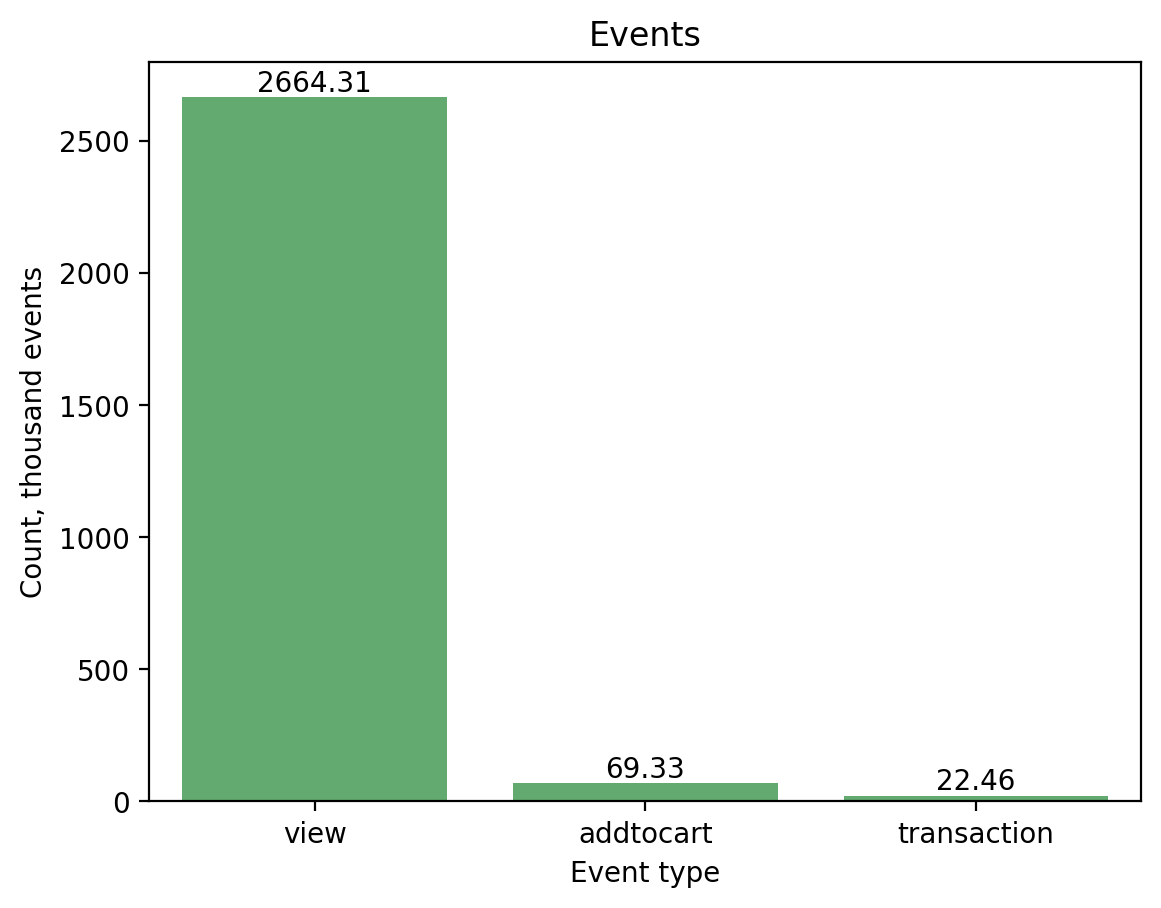

In [28]:
# Show unique event types
event_types = events["event_type"].value_counts()
fig, ax = plt.subplots()
plt.title("Events")
plt.xlabel("Event type")
plt.ylabel("Count, thousand events")
ax = sns.barplot(data=event_types/1e3, color=SINGLE_COLOR)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom")
plt.savefig(os.path.join(ASSETS_DIR, "EDA_event_type_distribution"))
plt.show()

In [29]:
# Calculate conversion
views = event_types.get("view", 0)
adds = event_types.get("addtocart", 0)
purchases = event_types.get("transaction", 0)
conversion_rate = (purchases / (views + adds)) * 100
print(f"Conversion Rate: {conversion_rate:.2}%")

Conversion Rate: 0.82%


Let's see how many unique users and items we have.

In [30]:
# Calculate unique users
print("Unique user_id count:", events["user_id"].nunique())

# Calculate unique items
print("Unique item_id count:", events["item_id"].nunique())

Unique user_id count: 1407580
Unique item_id count: 235061


Let's look at the total number of events per user.

In [31]:
# Calculate events per user
events_per_user = events.groupby("user_id")["event_type"].count().reset_index()
events_per_user.columns = ["user_id", "event_count"]
display(events_per_user.sort_values(by="event_count", ascending=False).reset_index(drop=True).head(10))

,user_id,event_count
0,1150086,7757
1,530559,4328
2,152963,3024
3,895999,2474
4,163561,2410
5,371606,2345
6,286616,2252
7,684514,2246
8,892013,2024
9,861299,1991


In [32]:
events_per_user["event_count"].describe()

count    1.407580e+06
mean     1.958042e+00
std      1.258049e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.757000e+03
Name: event_count, dtype: float64

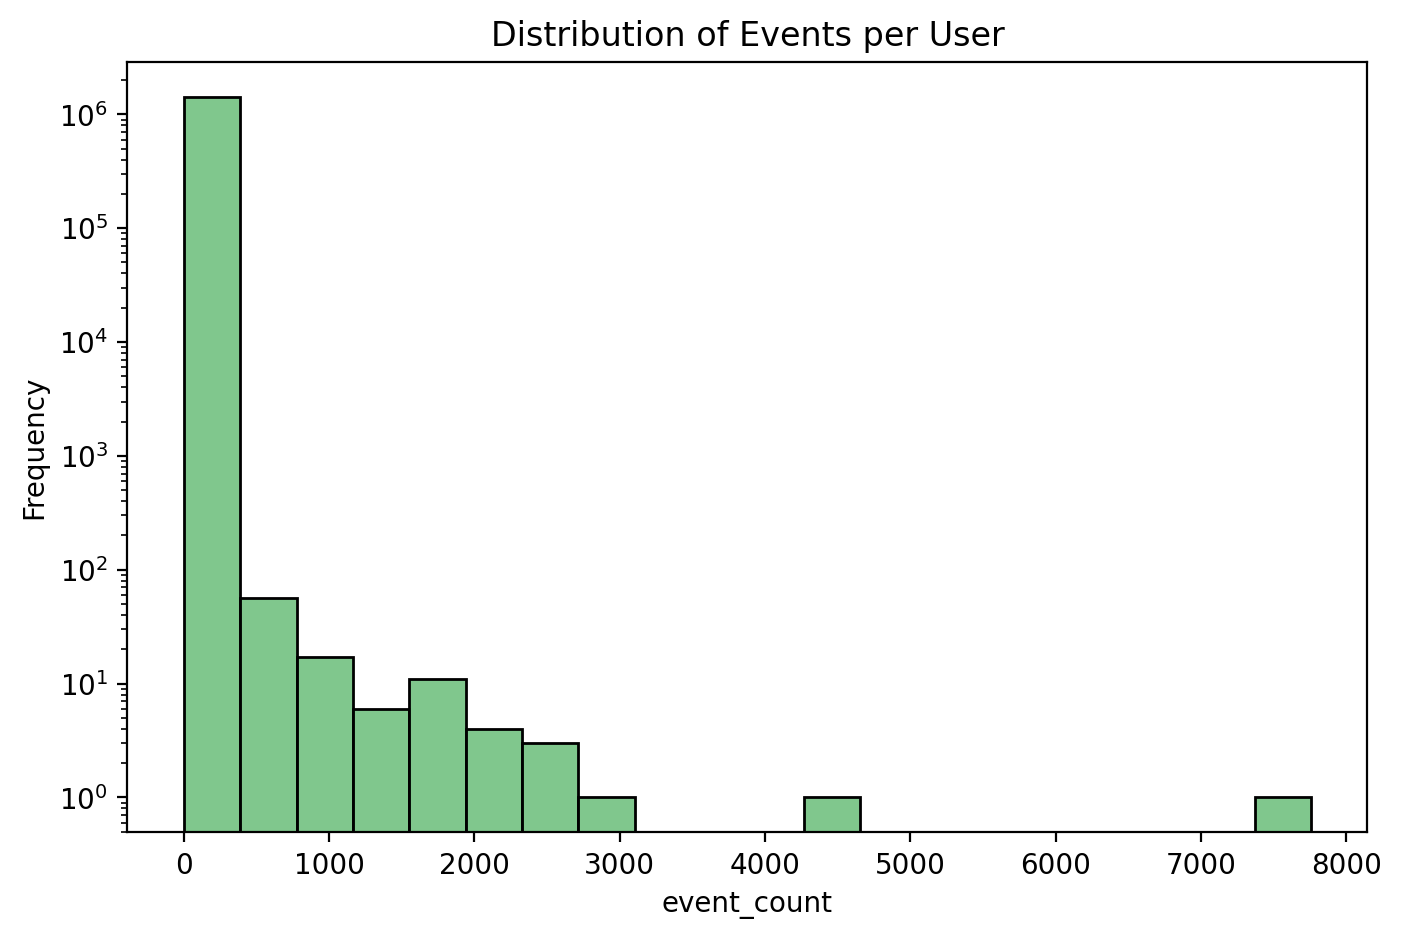

In [33]:
# Plotting the distribution of event counts
hist_log_y(
    data=events_per_user, 
    column="event_count",
    title="Distribution of Events per User",
    file_name="EDA_events_per_user"
)

Now let's look at the distribution of number of purchases among the users.

In [34]:
# Calculate purchases per user
purchases_per_user = events[events["event_type"]=="transaction"].groupby("user_id")["event_type"].count().reset_index()
purchases_per_user.columns = ["user_id", "purchase_count"]
display(purchases_per_user.sort_values(by="purchase_count", ascending=False).reset_index(drop=True).head(10))

,user_id,purchase_count
0,1150086,559
1,152963,349
2,530559,286
3,684514,189
4,861299,188
5,76757,185
6,138131,173
7,890980,145
8,1297062,136
9,247235,132


In [35]:
purchases_per_user["purchase_count"].describe()

count    11719.000000
mean         1.916290
std          8.850529
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        559.000000
Name: purchase_count, dtype: float64

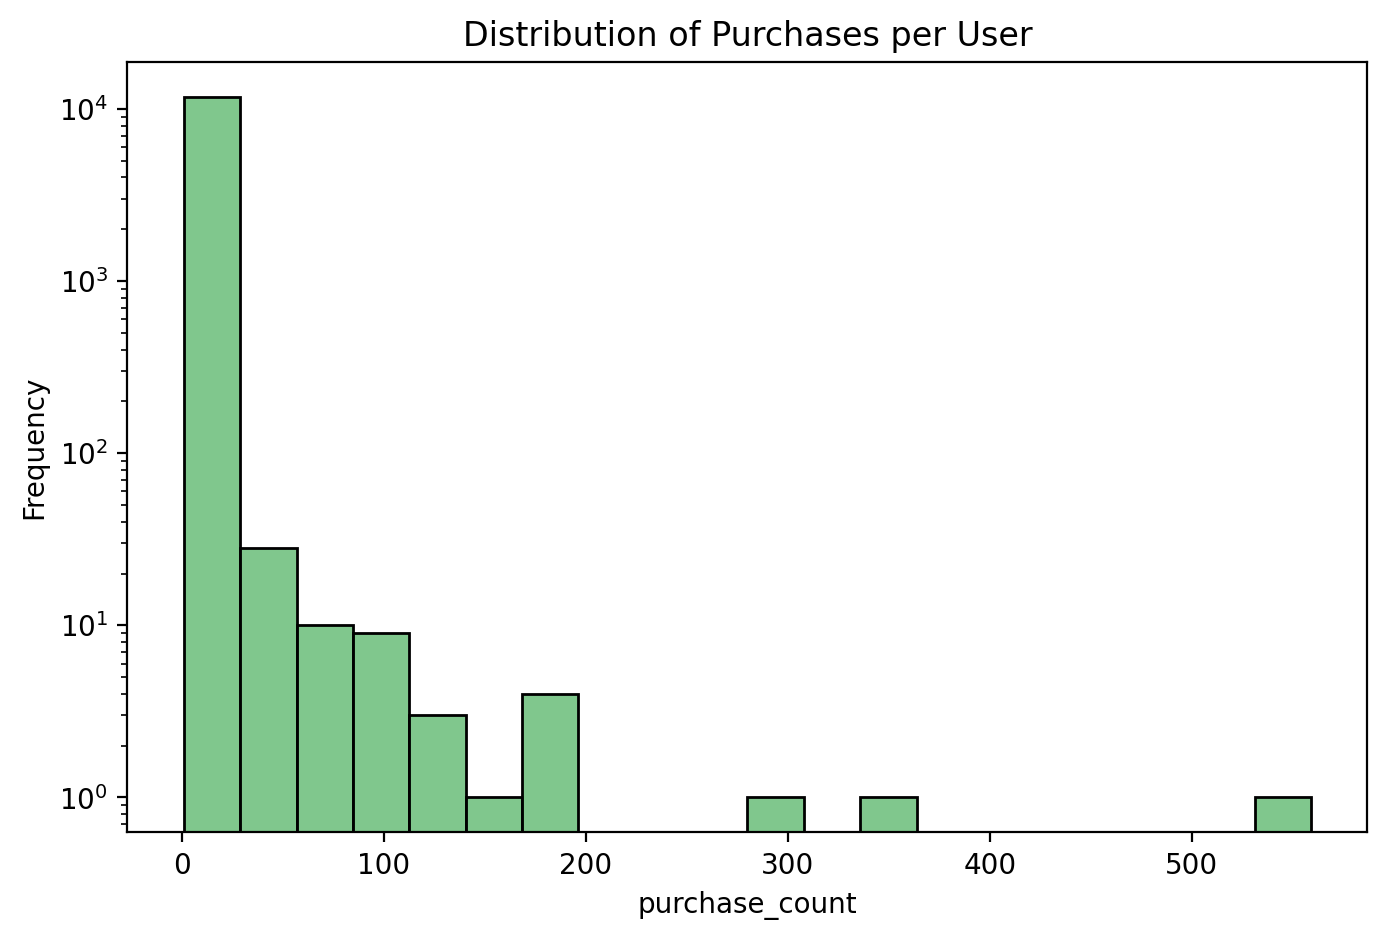

In [36]:
# Plotting the distribution of purchase counts
hist_log_y(
    data=purchases_per_user, 
    column="purchase_count",
    title="Distribution of Purchases per User",
    file_name="EDA_purchases_per_user"
)

In [37]:
# Calculate unique item purshased per user
items_per_user = events[events["event_type"]=="transaction"].groupby("item_id")["event_type"].count().reset_index()
items_per_user.columns = ["user_id", "item_count"]
display(items_per_user.sort_values(by="item_count", ascending=False).reset_index(drop=True).head(10))

,user_id,item_count
0,461686,133
1,119736,97
2,213834,92
3,7943,46
4,312728,46
5,445351,45
6,48030,41
7,420960,38
8,248455,38
9,17478,37


In [38]:
items_per_user["item_count"].describe()

count    12025.000000
mean         1.867526
std          2.710560
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        133.000000
Name: item_count, dtype: float64

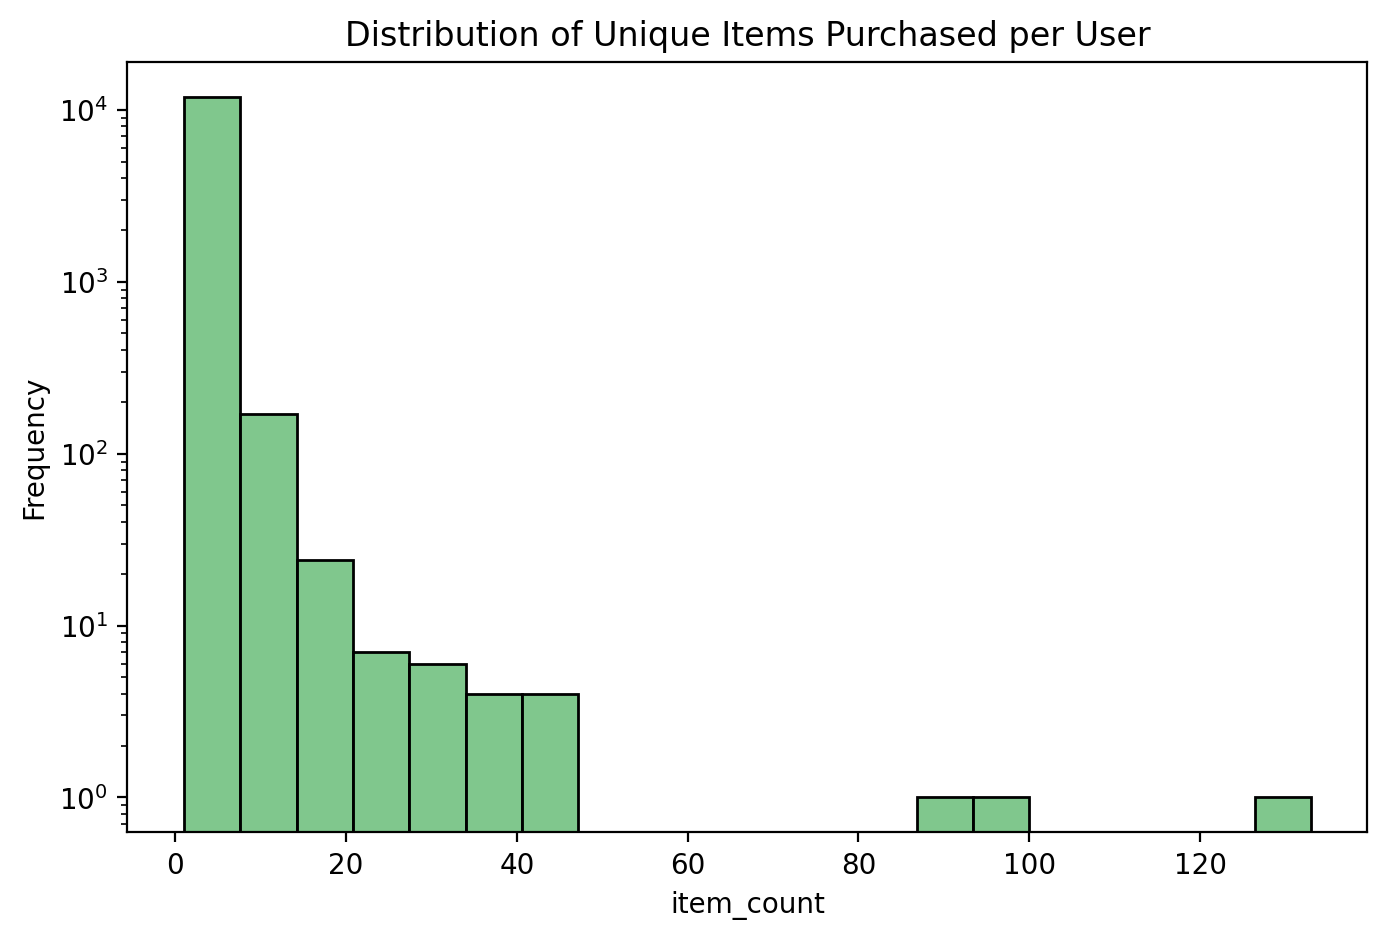

In [39]:
# Plotting the distribution of unique item purshased per user
hist_log_y(
    data=items_per_user, 
    column="item_count",
    title="Distribution of Unique Items Purchased per User",
    file_name="EDA_unique_items_purchased_per_user"
)

Let's see if there is a seasonality pattern in purchases.

In [40]:
# Add day_of_week feature
events["day_of_week"] = events["timestamp"].dt.dayofweek

In [41]:
# Calculate purchases per day of week
purchases_per_day_of_week = events[events["event_type"]=="transaction"].groupby("day_of_week")["user_id"].count().reset_index()
purchases_per_day_of_week.columns = ["day_of_week", "purchase_count"]
display(purchases_per_day_of_week.sort_values(by="purchase_count", ascending=False).reset_index(drop=True).head(10))

,day_of_week,purchase_count
0,2,4151
1,1,3973
2,0,3848
3,3,3750
4,4,2929
5,6,1995
6,5,1811


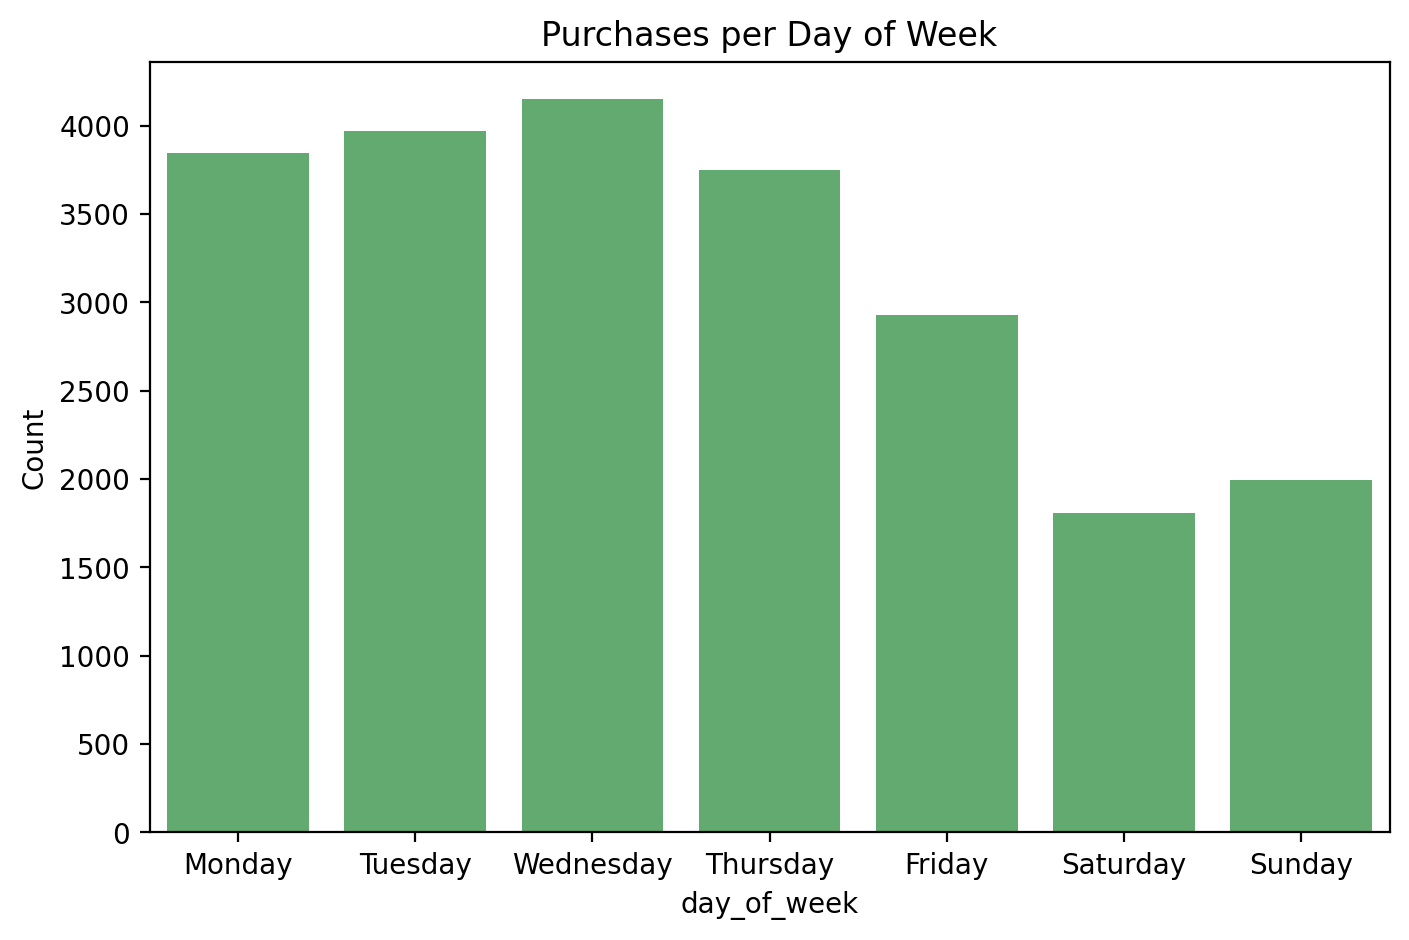

In [42]:
# Plot purchase count per day of week
plt.figure(figsize=(8,5))
sns.barplot(
    data=purchases_per_day_of_week,
    x="day_of_week", 
    y="purchase_count", 
    color=SINGLE_COLOR
)
day_labels = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
              4: "Friday", 5: "Saturday", 6: "Sunday"}
plt.gca().set_xticklabels([day_labels[day] for day in purchases_per_day_of_week["day_of_week"]])
plt.ylabel("Count")
plt.title("Purchases per Day of Week")
plt.savefig(os.path.join(ASSETS_DIR, "EDA_purchases_per_day_of_week"))
plt.show()

In [43]:
# Add rating based on the event type
events["rating"] = events["event_type"].map({"view": 1, 
                                             "addtocart": 3, 
                                             "transaction": 5})
# Delete event_type and day_of_week
events = events.drop(columns=["event_type", "day_of_week"])

**Observations:**
* The number of unique users is 1,407,580.
* The number of unique items is 235,061.
* The conversion rate is 0.82%.
* The distribution of events follows a logarithmic pattern, ranging from 1 to 7,757.
* The distribution of transactions (purchases) follows a logarithmic pattern, ranging from 1 to 559.
* The distribution of unique items per user follows a logarithmic pattern, ranging from 1 to 133.
* There is a significant difference in purchase counts between weekdays and weekends.

Recommender systems require some form of rating for items from users. We will map the events as follows:
* Rating 1 for "View"
* Rating 3 for "Add to Cart"
* Rating 5 for "Transaction"

A wider scale emphasizes the differences in user intent. For example, a transaction (rating 5) clearly signifies stronger interest compared to a view (rating 1).

### Item Properties

We observed that the `item_properties` table contains a large amount of data. Due to computational resource limitations, we cannot use all the properties, so we will select only the most significant ones.

In [44]:
print("Number of unique properties:", item_properties["property"].nunique())
print("Number of unique items:", item_properties["item_id"].nunique())

Number of unique properties: 1104
Number of unique items: 417053


In [45]:
# Show non-numeric properties
print(item_properties["property"][~item_properties["property"].str.isdigit()].unique())

['available' 'categoryid']


This gives us two insights:
* We need to exclude unavailable items from recommendations.
* We can merge `items_properties` and `categories` datasets on the `category_id`.

Let's evaluate property frequency.

In [46]:
# Calculate how many items have certain property
property_usage = item_properties["property"].value_counts()

threshold_range = np.arange(0.1, 1.1, 0.1)
properties_count = []

for threshold in threshold_range:
    threshold_abs = int(item_properties["item_id"].nunique() * threshold)
    properties_count.append(len(property_usage[property_usage >= threshold_abs].index))

properties_bins = pd.DataFrame({"threshold": threshold_range,
                                "properties_count": properties_count
                               })
properties_bins

,threshold,properties_count
0,0.1,37
1,0.2,24
2,0.3,20
3,0.4,19
4,0.5,18
5,0.6,17
6,0.7,16
7,0.8,15
8,0.9,15
9,1.0,9


We will take only the properties appearing in at least 20% of the items.

In [47]:
# Save frequent properties
threshold_abs = int(item_properties["item_id"].nunique() * 0.2)
frequent_properties = property_usage[property_usage >= threshold_abs].index

In [48]:
# Save filtered_item_properties df
filtered_item_properties = item_properties[item_properties["property"].isin(frequent_properties)]

**Observations:**
* There are 1,104 unique properties in the dataset.
* The property `available` should be taken into consideration when recommending items to users.
* The property `categoryi`d can be used to merge the `item_properties` and `categories` datasets.
* Only 37 properties are shared among more than 10% of the items.

### Creating `items` dataframe

In [49]:
# Create items df with frequent_properties as columns
items = filtered_item_properties.pivot_table(
    index="item_id", 
    columns="property", 
    values="property_value", 
    aggfunc="first"
).reset_index()

items = items.rename(columns = {"categoryid" : "category_id", "available": "is_available"})
items["is_available"] = items["is_available"].astype("int")
items["category_id"] = items["category_id"].astype("int")

items.head()

property,item_id,1036,112,159,202,227,28,283,348,364,...,764,776,790,810,839,888,917,928,is_available,category_id
0,0,1276750,679677,519769,478989,1152934 1238769,NaN,66094 372274 478989,NaN,20716,...,1285872,318611,n91200.000,NaN,372274,478989,478989,NaN,0,209
1,1,1154859,679677,519769,172646,1020281 150169 1263524,NaN,513325 1020281 1204938 172646 72261 30603 8980...,NaN,1299107,...,1285872,379040,n6120.000,NaN,1204938,172646 1154859,n372361069212.000,NaN,0,1114
2,2,NaN,679677,519769,648485 n6000.000 n72.000,NaN,NaN,822092 325894 504272 147366 343631 648485 n600...,NaN,1260440,...,1285872,1005623,n41040.000,NaN,147366 343631,648485 n6000.000 n72.000 n72.000 468140,648485 n6000.000 639502 n72.000,NaN,0,1305
3,3,NaN,679677,519769,261419,1305767,NaN,1305767 150169 1182824 327918 261419,NaN,354388,...,1285872,284910,n1560.000,NaN,327918,261419,261419 829653,NaN,0,1171
4,4,NaN,679677,519769,371058 71429,588652 1091491,150169 176547,588652 768453 508476 371058 71429,NaN,1142657,...,1285872,571860,n468360.000,NaN,508476,371058 71429,76856,NaN,0,1038


In [50]:
# Merge items and categories
items = items.merge(categories, on="category_id", how="left")
items["parent_category_id"] = items["parent_category_id"].fillna(-1).astype("int")
items.head()

,item_id,1036,112,159,202,227,28,283,348,364,...,776,790,810,839,888,917,928,is_available,category_id,parent_category_id
0,0,1276750,679677,519769,478989,1152934 1238769,NaN,66094 372274 478989,NaN,20716,...,318611,n91200.000,NaN,372274,478989,478989,NaN,0,209,293
1,1,1154859,679677,519769,172646,1020281 150169 1263524,NaN,513325 1020281 1204938 172646 72261 30603 8980...,NaN,1299107,...,379040,n6120.000,NaN,1204938,172646 1154859,n372361069212.000,NaN,0,1114,113
2,2,NaN,679677,519769,648485 n6000.000 n72.000,NaN,NaN,822092 325894 504272 147366 343631 648485 n600...,NaN,1260440,...,1005623,n41040.000,NaN,147366 343631,648485 n6000.000 n72.000 n72.000 468140,648485 n6000.000 639502 n72.000,NaN,0,1305,1214
3,3,NaN,679677,519769,261419,1305767,NaN,1305767 150169 1182824 327918 261419,NaN,354388,...,284910,n1560.000,NaN,327918,261419,261419 829653,NaN,0,1171,938
4,4,NaN,679677,519769,371058 71429,588652 1091491,150169 176547,588652 768453 508476 371058 71429,NaN,1142657,...,571860,n468360.000,NaN,508476,371058 71429,76856,NaN,0,1038,1174


In [51]:
items_stats = pd.DataFrame({
    "column_name": items.columns,
    "missing_values": items.isna().sum().values,
    "unique_values": [items[col].nunique(dropna=True) for col in items.columns]
})
display(items_stats)

,column_name,missing_values,unique_values
0,item_id,0,417053
1,1036,314461,1218
2,112,0,1
3,159,0,1
4,202,2836,278049
5,227,88957,4842
6,28,247127,186
7,283,0,325121
8,348,306451,974
9,364,0,417039


Features with 1 unique category and no missing values have no use for the model as they are constant.

In [52]:
# Delete features
columns_to_delete = items_stats[(items_stats["missing_values"]==0)&(items_stats["unique_values"]==1)]["column_name"].tolist()
items = items.drop(columns=columns_to_delete)
print("Deleted features:", columns_to_delete)

# Fill the rest of NaN with -1
items = items.fillna(-1)

Deleted features: ['112', '159', '764']


To prevent the situation when we item ids `events` but don't have them in `items`, we will filter out these invalid ids.

In [53]:
# Get valid item IDs from the `items` DataFrame
valid_item_ids = set(items["item_id"])

# Filter the `events` DataFrame to keep only rows with valid `item_id`
events = events[events["item_id"].isin(valid_item_ids)]

Let's see the data we are going to work with one more time.

In [54]:
items.head(3)

,item_id,1036,202,227,28,283,348,364,6,678,...,776,790,810,839,888,917,928,is_available,category_id,parent_category_id
0,0,1276750,478989,1152934 1238769,-1,66094 372274 478989,-1,20716,66094,372274,...,318611,n91200.000,-1,372274,478989,478989,-1,0,209,293
1,1,1154859,172646,1020281 150169 1263524,-1,513325 1020281 1204938 172646 72261 30603 8980...,-1,1299107,1020281,1204938,...,379040,n6120.000,-1,1204938,172646 1154859,n372361069212.000,-1,0,1114,113
2,2,-1,648485 n6000.000 n72.000,-1,-1,822092 325894 504272 147366 343631 648485 n600...,-1,1260440,-1,147366 343631,...,1005623,n41040.000,-1,147366 343631,648485 n6000.000 n72.000 n72.000 468140,648485 n6000.000 639502 n72.000,-1,0,1305,1214


In [55]:
events.head(3)

,timestamp,user_id,item_id,rating
id,,,,
1,2015-06-02 05:02:00,257597,355908,1
2,2015-06-02 05:50:00,992329,248676,1
4,2015-06-02 05:12:00,483717,253185,1


In [56]:
# Logging
if mlflow_logging == 1:
    with mlflow.start_run(run_id=run_id) as run:
        print(f"Experiment: {EXPERIMENT_NAME} (id={experiment_id})")
        print(f"Run: {run.info.run_name} (id={run_id})\n")
        mlflow.log_artifacts(ASSETS_DIR, "ASSETS")
else:
    pass

Experiment: RECSYS_ECOMMERCE_YORDANOVA (id=9)
Run: recsys_development (id=dbe42813e1064c8eb292ca1b41bd7676)



2024/12/12 07:49:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run recsys_development at: http://127.0.0.1:5000/#/experiments/9/runs/dbe42813e1064c8eb292ca1b41bd7676.
2024/12/12 07:49:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9.


### Stage results

* The number of unique users is 1,407,580.
* The number of unique items in the `events` table is 235,061.
* The conversion rate is 0.82%.
* The distribution of events follows a logarithmic pattern, ranging from 1 to 7,757.
* The distribution of transactions (purchases) follows a logarithmic pattern, ranging from 1 to 559.
* The distribution of unique items per user follows a logarithmic pattern, ranging from 1 to 133.
* There is a significant difference in purchase counts between weekdays and weekends.
* There are 1,104 unique properties in the dataset.
* Only 24 properties are shared among more than 20% of the items.
* The property `available` should be taken into consideration when recommending items to users.
* The property `categoryid` can be used to merge the `item_properties` and `categories` datasets.
* Number of unique items in the `items` table is 417,053.

## 3. Recommender System Development

In [57]:
if practicum_mode == "on": 
    print("Events before filtering:")
    print(f'- rows: {events.shape[0]}\n- unique users: {events["user_id"].nunique()}\n- unique items: {events["item_id"].nunique()}')
    
    # Choose 10% users from events with stratification by number of events  
    """
    events = events.groupby("user_id").sample(frac=0.1, random_state=RANDOM_STATE)
    filtered_items_ids = events["item_id"].unique().tolist()
    items = items[items["item_id"].isin(filtered_items_ids)]
    filtered_items_ids = events["item_id"].unique().tolist()
    items = items[items["item_id"].isin(filtered_items_ids)]
    columns_to_unify_type = items.select_dtypes(include="object").columns.tolist()
    items[columns_to_unify_type] = items[columns_to_unify_type].astype("str")
    
    items.to_parquet("data/items_filtered.parquet")
    events.to_parquet("data/events_filtered.parquet")
    """
    
    events = pd.read_parquet("data/events_filtered.parquet")   
    items = pd.read_parquet("data/items_filtered.parquet")
    
    print("\nEvents after filtering:")
    print(f'- rows: {events.shape[0]}\n- unique users: {events["user_id"].nunique()}\n- unique items: {events["item_id"].nunique()}')

Events before filtering:
- rows: 2500516
- unique users: 1236032
- unique items: 185246

Events after filtering:
- rows: 88519
- unique users: 55946
- unique items: 36303


### Items Availability and Users Eligibility

We need to incentivize users to buy items; that is why it is crucial to recommend only the items that are currently available in the shop. To achieve this, we will create a table that stores information about the current availability of all the items, and we will take this information into consideration when making recommendations.

In [58]:
# Create a list of available items
def get_available_items(items_df):
    """
    Get list of item_ids where property is_available = 1.

    Parameters:
        items_df: pd.DataFrame with items.

    Returns:
        available_items: list.
    """
    available_items = items_df[items_df["is_available"]==1]["item_id"].tolist()
    return available_items

Personalized recommendations are the recommendations based on user's behavior (views, adds to cart, transactions). We will make personalized recommendations only for users with more than N unique items in their history. N - is the PERSONALIZED_RECOMMENDATIONS_THRESHOLD setting.

In [59]:
# Get the list of interacted items
def get_user_history(user_id, events_df):
    """
    Get list of item_ids given user interacted with.

    Parameters:
        user_id: int.
        events_df: pd.DataFrame with interactions.

    Returns:
        interacted_items: list.
    """
    interacted_items = events_df[events_df["user_id"]==user_id]["item_id"].unique().tolist()
    return interacted_items

In [60]:
# Get eligible users for personalized recommendations
def get_eligible_users(events_df, threshold):
    """
    Get list of user_ids with number of unique 
    interacted items more or equal to threshold.

    Parameters:
        events_df: pd.DataFrame with interactions.
        threshold: int.

    Returns:
        eligible_users: list.
    """
    all_users = events_df["user_id"].unique().tolist()
    eligible_users = []
    for user in all_users:
        interacted_items = get_user_history(user, events_df)
        if len(interacted_items) >= threshold:
            eligible_users.append(user)
    return eligible_users

### Train/test split

We will split the dataset using global date - 21.08.2015.

In [61]:
# Splitting the data
split_idx = events["timestamp"] < pd.to_datetime(TEST_SPLIT_DATE)
events_train = events[split_idx]
events_test = events[~split_idx]

In [62]:
# Calculate number of users
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
print(f"Users (train):  {len(users_train)}")
print(f"Users (test):   {len(users_test)}")

# Calculate common users
common_users = set(users_train) & set(users_test)
print(f"Common users:   {len(common_users)}")

# Calculate cold users
cold_users = set(users_test) - set(common_users)
print(f"Cold users:     {len(cold_users)}")

Users (train):  47172
Users (test):   9471
Common users:   697
Cold users:     8774


We need to encode item and user ids in the `events` dataset with LabelEncoder, this is a required step for creating user-item-matrix.

In [63]:
# Fit encoder for user_id
user_encoder = LabelEncoder()
user_encoder.fit(events["user_id"])

events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Fit encoder for item_id
item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])

items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [64]:
# Save encoders to files locally
joblib.dump(user_encoder, "model/user_encoder.pkl")
joblib.dump(item_encoder, "model/item_encoder.pkl")

# Save encoders to S3
s3 = get_s3_session()
s3.upload_file("model/user_encoder.pkl", S3_BUCKET, "mle_final/model/user_encoder.pkl")
s3.upload_file("model/item_encoder.pkl", S3_BUCKET, "mle_final/model/item_encoder.pkl")

In [65]:
# Logging
if mlflow_logging == 1:
    with mlflow.start_run(run_id=run_id) as run:
        print(f"Experiment: {EXPERIMENT_NAME} (id={experiment_id})")
        print(f"Run: {run.info.run_name} (id={run.info.run_id})\n")
        mlflow.sklearn.log_model(user_encoder, "MODEL/encoders/user_encoder")
        mlflow.sklearn.log_model(item_encoder, "MODEL/encoders/item_encoder")
else:
    pass

2024/12/12 07:49:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Experiment: RECSYS_ECOMMERCE_YORDANOVA (id=9)
Run: recsys_development (id=dbe42813e1064c8eb292ca1b41bd7676)



2024/12/12 07:49:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/12 07:49:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/12 07:49:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/12 07:49:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run recsys_development at: http://127.0.0.1:5000/#/experiments/9/runs/dbe42813e1064c8eb292ca1b41bd7676.
2024/12/12 07:49:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9.


### Default Recommendations (Top 100 Popular Items)

We will calculate default recommendations as the top 100 popular items (purchased or added to cart) from the training sample. These will be the recommendations that we will show to "cold" users, about whose preferences we know nothing or too little (PERSONALIZED_RECOMMENDATIONS_THRESHOLD setting).

In [66]:
def get_default_recommendations(events_df, items_df):
    """
    Creates a table with top 100 popular items as default 
    recommendations.

    Parameters:
        events_df: pd.DataFrame with interactions.
        items_df: pd.DataFrame with items.

    Returns:
        default_recommendations: pd.Dataframe 
        with created recommendations.
    """
    available_items = get_available_items(items_df)
    default_recommendations = events_df[
    ((events_df["rating"]>1)
     &(events_df["item_id"].isin(available_items)))
    ].groupby("item_id")["user_id"].count()
    
    default_recommendations = default_recommendations.sort_values(ascending=False).head(100)
    default_recommendations = pd.DataFrame({"item_id": default_recommendations.index,
                                            "count": default_recommendations.values})
    default_recommendations = default_recommendations.sort_values(by="count", ascending=False)

    return default_recommendations

In [67]:
# Create default recommendations for cold users
default_recommendations = get_default_recommendations(events, items)

# Save to file
default_recommendations.to_parquet("recommendations/default_recommendations.parquet")

# Save to S3
s3 = get_s3_session()
s3.upload_file("recommendations/default_recommendations.parquet", S3_BUCKET, "mle_final/recommendations/default_recommendations.parquet")

default_recommendations.head(10)

,item_id,count
0,461686,38
1,409804,16
2,119736,15
3,9877,12
4,7943,10
5,320130,10
6,208939,9
7,312728,9
8,32581,9
11,65273,8


In [68]:
# Upload dataframe to the database
default_recommendations = default_recommendations.reset_index(drop=False)
create_dynamic_table(df=default_recommendations, index_col="index", table_name="recsys_default_recommendations")          
insert_dataframe_to_table(default_recommendations, "recsys_default_recommendations")

### Personalized Recommendations

To create personalized recommendations, we will start with creating a user-item matrix where the rows will represent users, columns - items and values - rating. And then we will train ALS model with 100 latent factors.

In [69]:
# Get list of eligible users
eligible_users = get_eligible_users(events_train, PERSONALIZED_RECOMMENDATIONS_THRESHOLD)
print(f"Users with {PERSONALIZED_RECOMMENDATIONS_THRESHOLD} or more unique interacted items: {len(eligible_users)}")

Users with 3 or more unique interacted items: 2641


In [70]:
# Create U-I matrix
user_item_matrix_train = csr_matrix(
    (
        events_train["rating"],
        (events_train["user_id_enc"], events_train["item_id_enc"])
    ), 
    dtype=np.uint8)

In [71]:
# Create ALS-model
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=RANDOM_STATE)
als_model.fit(user_item_matrix_train)

  0%|          | 0/50 [00:00<?, ?it/s]

We will exclude the items the user has already interacted with. Our aim is to increase the number of items the user clicks on; therefore, interacted items will be displayed in a separate section ("You have seen these items").

In [72]:
def get_personalized_recommendations(
    user_item_matrix, model, user_id, 
    user_encoder, item_encoder, items_df, n=5
):
    """
    Creates a table with N (default = 5) personalized 
    recommendations for user_id using ALS model.

    Parameters:
        user_item_matrix: sparse users-items matrix.
        model: trained ALS model.
        user_id: int.
        user_encoder: trained LabelEncoder for user_ids.
        item_encoder: trained LabelEncoder for item_ids.
        items_df: pd.DataFrame with items.
        n: int, number of recommendations per user, 
           default = 5.

    Returns:
        recommendations: pd.Dataframe 
        with created recommendations.
    """
    # Get available items
    available_items = get_available_items(items_df)
    
    # Encode user ID
    user_id_enc = user_encoder.transform([user_id])[0]
  
    # Get recommendations
    recommendations = model.recommend(
        user_id_enc, 
        user_item_matrix[user_id_enc], 
        filter_already_liked_items=True,
        N=n*10
    )
    
    recommendations = pd.DataFrame({
        "user_id": user_id,
        "item_id_enc": recommendations[0], 
        "score": recommendations[1]
    })
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    # Exclude unavailable items
    recommendations = recommendations[recommendations["item_id"].isin(available_items)]
    recommendations = recommendations[["user_id", "item_id", "score"]].head(n)
    
    # Return the top N recommendations after filtering
    return recommendations

In [73]:
# Test the function
sample_user_id = events_train["user_id"].sample(random_state=RANDOM_STATE).iat[0]
get_personalized_recommendations(user_item_matrix_train, als_model, sample_user_id, user_encoder, item_encoder, items, 5)

,user_id,item_id,score
0,138131,216266,0.185696
3,138131,130352,0.156495
4,138131,47174,0.154908
5,138131,68704,0.148158
6,138131,457970,0.118230


In [74]:
# Create personalized recommendations for all users
recommendations = []

for user in tqdm(eligible_users):
    user_recommendations = get_personalized_recommendations(
        user_item_matrix_train, 
        als_model, 
        user, 
        user_encoder, 
        item_encoder, 
        items, 
        n=5
    )
    recommendations.append(user_recommendations)

# Concatenate all recommendations into DataFrame
personalized_recommendations = pd.concat(recommendations, ignore_index=True)

personalized_recommendations.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2641/2641 [00:36<00:00, 71.49it/s]


,user_id,item_id,score
0,172,464731,0.000931
1,172,208939,0.000702
2,172,287449,0.000592
3,172,339703,0.000565
4,172,312728,0.000545
5,1879,213834,0.053874
6,1879,287449,0.036852
7,1879,12217,0.026973
8,1879,420960,0.026276
9,1879,339703,0.022780


### Similar Items

Another type of recommendations is i2i, recommendations of similar items. We will use the same ALS model to create them.

In [75]:
def get_similar_items(model, item_id, item_encoder, n_similar=5):
    """
    Finds similar items fror given item_id.

    Parameters:
        model: trained ALS model.
        item_id: int.
        item_encoder: trained LabelEncoder for item_ids.
        n_similar: int, number of similar items for item_id,
                   default = 5.

    Returns:
        result: list of dictionaries.
    """
    item_id_enc = item_encoder.transform([item_id])[0]
    similar_items = model.similar_items(item_id_enc, N=n_similar+1)

    similar_item_ids_enc = similar_items[0]
    similarity_scores = similar_items[1]

    similar_item_ids = item_encoder.inverse_transform(similar_item_ids_enc)
    
    result = [(item_id, similar_item_id, score) 
              for similar_item_id, score 
              in zip(similar_item_ids, similarity_scores) 
              if similar_item_id != item_id]
    
    return result

In [76]:
# Test the function
sample_item_id = events_train["item_id"].sample(random_state=RANDOM_STATE).iat[0]
get_similar_items(als_model, sample_item_id, item_encoder, n_similar=3)

[(49341, 392302, 0.945601),
 (49341, 257550, 0.945005),
 (49341, 191461, 0.9443983)]

In [77]:
def get_i2i_recommendations_for_items(items_df, model, item_encoder, n=5):
    """
    Creates a table with N similar items for every 
    unique item_id in the items table.

    Parameters:
        items_df: pd.DataFrame with items.
        model: trained ALS model.
        item_id: int.
        item_encoder: trained LabelEncoder for item_ids.
        n: int, number of similar items for item_id,
           default = 5.

    Returns:
        recommendations: pd.Dataframe 
        with found similar.items.
    """
    unique_items = items["item_id"].unique().tolist()
    all_similar_items = []
    
    for item_id in tqdm(unique_items):
        item_similar_items = get_similar_items(model, item_id, item_encoder, n_similar=n)
        item_similar_items_flat = [(item_id, similar_item_id, score) for item_id, similar_item_id, score in item_similar_items]
        similar_items_df = pd.DataFrame(item_similar_items_flat, columns=["item_id", "similar_item_id", "score"])
        all_similar_items.append(similar_items_df)
    
    recommendations = pd.concat(all_similar_items, ignore_index=True)
    
    return recommendations

In [78]:
# Create i2i recommendations for all items
similar_items = get_i2i_recommendations_for_items(
    items, 
    als_model,
    item_encoder,
    n=5
)

# Save to file
similar_items.to_parquet("recommendations/similar_items.parquet")

# Save to S3
s3 = get_s3_session()
s3.upload_file("recommendations/similar_items.parquet", S3_BUCKET, "mle_final/recommendations/similar_items.parquet")

similar_items.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36303/36303 [01:19<00:00, 458.03it/s]


,item_id,similar_item_id,score
0,6,341416,1.000000
1,6,367497,0.999999
2,6,23248,0.999995
3,6,338411,0.996126
4,6,120218,0.995614
5,19,325905,0.996951
6,19,270660,0.996877
7,19,307828,0.996706
8,19,421372,0.996698
9,19,56698,0.996591


In [79]:
# Upload dataframe to the database
similar_items = similar_items.reset_index(drop=False)
create_dynamic_table(df=similar_items, index_col="index", table_name="recsys_similar_items")
insert_dataframe_to_table(similar_items, "recsys_similar_items")

In [80]:
def get_i2i_recommendations_for_user(events_df, model, user_id, item_encoder, n=5):
    """
    Creates a table with N i2i recommendations 
    for user_id using ALS model.

    Parameters:
        events_df: pd.DataFrame with interactions.
        model: trained ALS model.
        user_id: int.
        item_encoder: trained LabelEncoder for item_ids.
        n: int, number of similar items for each item_id
           in user's history of interactions, default = 5.

    Returns:
        recommendations: pd.Dataframe 
        with created recommendations.
    """
    user_history = get_user_history(user_id, events_df)
    user_similar_items = []
    
    for item_id in user_history:
        similar_items = get_similar_items(model, item_id, item_encoder, n_similar=2)
        similar_items_flat = [(item_id, similar_item_id, score) for item_id, similar_item_id, score in similar_items]
        i2i_recommendations = pd.DataFrame(similar_items_flat, columns=["based_on_item_id", "item_id", "score"])
        user_similar_items.append(i2i_recommendations)
    
    recommendations = pd.concat(user_similar_items, ignore_index=True)
    recommendations = recommendations[~recommendations["item_id"].isin(user_history)]
    recommendations["user_id"] = user_id
    recommendations = recommendations[["user_id", "item_id", "score", "based_on_item_id"]]
    recommendations = recommendations.sort_values(by="score", ascending=False).head(n)
    
    return recommendations

In [81]:
# Create i2i recommendations for all users
recommendations = []

for user in tqdm(eligible_users):
    user_recommendations = get_i2i_recommendations_for_user(
        events_train, 
        als_model, 
        user, 
        item_encoder
    )
    recommendations.append(user_recommendations)

# Concatenate all recommendations into DataFrame
i2i_recommendations = pd.concat(recommendations, ignore_index=True)

i2i_recommendations.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2641/2641 [00:51<00:00, 51.49it/s]


,user_id,item_id,score,based_on_item_id
0,172,231011,0.999945,10034
1,172,41662,0.999944,79918
2,172,263245,0.999939,10034
3,172,301344,0.999933,79918
4,1879,458803,0.999876,83707
5,1879,60759,0.999875,83707
6,1879,191992,0.999184,83937
7,1879,51276,0.999184,83937
8,1879,295537,0.998890,126929
9,2326,436344,1.000000,315639


### Feature Engineering and Preparing Candidates

To make recommendations more precise, we will add a ranking model on top of the ALS model. First we will create features for users - `favorite_category_id`, `favorite_parent_category_id`.

In [82]:
# Find all the categories that user was interacting with
user_categories = pd.merge(events_train, items[["item_id", "category_id", "parent_category_id"]], on="item_id", how="left")

# Calculate the frequency
category_count = user_categories.groupby(["user_id", "category_id"]).size().reset_index(name="count")
parent_category_count = user_categories.groupby(["user_id", "parent_category_id"]).size().reset_index(name="count")

user_favorite_category = category_count.loc[category_count.groupby("user_id")["count"].idxmax()]
user_favorite_category = user_favorite_category[["user_id", "category_id"]].rename(columns={"category_id": "favorite_category_id"})

user_favorite_parent_category = parent_category_count.loc[parent_category_count.groupby("user_id")["count"].idxmax()]
user_favorite_parent_category = user_favorite_parent_category[["user_id", "parent_category_id"]].rename(columns={"parent_category_id": "favorite_parent_category_id"})

# Merge fav categories
user_favorite_categories = pd.merge(user_favorite_category, user_favorite_parent_category, on="user_id", how="outer")
user_favorite_categories

,user_id,favorite_category_id,favorite_parent_category_id
0,2,299,73
1,37,730,1482
2,64,317,314
3,74,1078,1249
4,75,683,1606
...,...,...,...
47167,1407476,56,1497
47168,1407479,628,149
47169,1407512,374,131
47170,1407527,29,1678


 Now we will prepare candidates and add target column: 1 - user interacted with suggested item, 0 - user did not interact with suggested item.

In [83]:
# Split events_test
split_idx = events_test["timestamp"] < pd.to_datetime(INFERENCE_SPLIT_DATE)
events_test_labels = events_test[split_idx]
events_test_inference = events_test[~split_idx]

users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
print(f"Number of users (test_labels):  {len(users_train)}")
print(f"Number of users (test_inference):   {len(users_test)}")

common_users = set(users_train) & set(users_test)
print(f"Common users:    {len(common_users)}")

cold_users = set(users_test) - set(common_users)
print(f"Cold users: {len(cold_users)}")

Number of users (test_labels):  47172
Number of users (test_inference):   9471
Common users:    697
Cold users: 8774


In [84]:
# Prepare candidates
candidates_train = pd.merge(
    personalized_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "pers_score"}),
    i2i_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "i2i_score"}),
    on=["user_id", "item_id"],
    how="outer"
)

candidates_train = candidates_train.merge(items[["item_id", "category_id", "parent_category_id"]], on="item_id", how="left")
candidates_train = candidates_train.merge(user_favorite_categories, on="user_id", how="left")

# Add target column:
# — 1 for interacted item_id
# — 0 for the rest

events_test_labels["target"] = 1
candidates_train = candidates_train.merge(
    events_test_labels[["user_id", "item_id", "target"]], 
    on=["user_id", "item_id"],
    how="left"
)

candidates_train["target"] = candidates_train["target"].fillna(0).astype("int")
candidates_train.head(10)

,user_id,item_id,pers_score,i2i_score,category_id,parent_category_id,favorite_category_id,favorite_parent_category_id,target
0,172,41662,NaN,0.999944,126,871,196,121,0
1,172,208939,0.000702,NaN,858,1426,196,121,0
2,172,231011,NaN,0.999945,1500,1515,196,121,0
3,172,263245,NaN,0.999939,1500,1515,196,121,0
4,172,287449,0.000592,NaN,858,1426,196,121,0
5,172,301344,NaN,0.999933,1205,580,196,121,0
6,172,312728,0.000545,NaN,1098,897,196,121,0
7,172,339703,0.000565,NaN,342,500,196,121,0
8,172,464731,0.000931,NaN,1219,121,196,121,0
9,1879,12217,0.026973,NaN,1375,805,769,859,0


It is normal to have `NaN` values in the table. This is because we are combining recommendations from two generators, and they do not always match, so there are gaps in the `pers_score` and `i2i_score` columns.

### Ranking Model

Next step - ranking model training. We chose a gradient boosting model as they show the best results comparing to more primitive models such as Logistic Regression, kNN etc. We will be using `CatBoostClassifier`.

In [85]:
# Create feature list and target
features = ["pers_score", "i2i_score", "category_id", "parent_category_id", "favorite_category_id", "favorite_parent_category_id"]
target = "target"

# Create pool-object
train_data = Pool(
    data=candidates_train[features], 
    label=candidates_train[target]
)

# Initialize CatBoostClassifier model
ranking_model = CatBoostClassifier(
    learning_rate=0.05,
    depth=5,
    loss_function="Logloss",
    verbose=0,
    random_seed=RANDOM_STATE
)

# Train ranking model
ranking_model.fit(train_data)

# Save model
joblib.dump(ranking_model, "model/ranking_model.pkl")

# Save to S3
s3 = get_s3_session()
s3.upload_file("model/ranking_model.pkl", S3_BUCKET, "mle_final/model/ranking_model.pkl")

# Load ranking model from S3
ranking_model = read_pkl_from_s3(S3_BUCKET, "mle_final/model/ranking_model.pkl")

Now we simulate a situation where some time has passed and new recommendations have already appeared. We need to retrain `als_model` on new data and make predictions with the ranking model based on the updated recommendations.

In [86]:
# Merge events_train and events_test_labels
events_train_new = pd.concat([events_train, events_test_labels.drop(columns=["target"])])
events_train_new = events_train_new.reset_index(drop=True)

In [87]:
# Create new U-I matrix
user_item_matrix_train_new = csr_matrix(
    (np.ones(len(events_train_new)), (events_train_new["user_id_enc"], events_train_new["item_id_enc"])),
    dtype=np.uint8)

In [88]:
# Re-train ALS model
als_model_new = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=RANDOM_STATE)
als_model_new.fit(user_item_matrix_train_new)

# Save model
joblib.dump(als_model_new, "model/als_model_new.pkl")

# Save to S3
s3 = get_s3_session()
s3.upload_file("model/als_model_new.pkl", S3_BUCKET, "mle_final/model/als_model_new.pkl")

  0%|          | 0/50 [00:00<?, ?it/s]

In [89]:
# Logging
if mlflow_logging == 1:
    with mlflow.start_run(run_id=run_id) as run:
        print(f"Experiment: {EXPERIMENT_NAME} (id={experiment_id})")
        print(f"Run: {run.info.run_name} (id={run.info.run_id})\n")
                
        # Logging ALS model
        1
        als_model_wrapper = ALSModelWrapper(als_model=als_model_new)
        pip_requirements = "requirements.txt"
        metadata = {"model_type": "weekly"}
        if mlflow_register_model == 1:
            registered_model_name = REGISTRY_ALS_MODEL_NAME
        else:
            registered_model_name = None
        model_info = mlflow.pyfunc.log_model(
            artifact_path="MODEL/als_model", 
            python_model=als_model_wrapper,
            pip_requirements=pip_requirements,
            metadata=metadata,
            signature=False,
            registered_model_name=registered_model_name,
            await_registration_for=60
    )
else:
    pass

2024/12/12 07:52:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment: RECSYS_ECOMMERCE_YORDANOVA (id=9)
Run: recsys_development (id=dbe42813e1064c8eb292ca1b41bd7676)



Successfully registered model 'RECSYS_ECOMMERCE_ALS_MODEL'.
2024/12/12 07:52:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: RECSYS_ECOMMERCE_ALS_MODEL, version 1
Created version '1' of model 'RECSYS_ECOMMERCE_ALS_MODEL'.
2024/12/12 07:52:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run recsys_development at: http://127.0.0.1:5000/#/experiments/9/runs/dbe42813e1064c8eb292ca1b41bd7676.
2024/12/12 07:52:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9.


In [90]:
# Get list of eligible users
eligible_users = get_eligible_users(events_train_new, PERSONALIZED_RECOMMENDATIONS_THRESHOLD)
print(f"Users with {PERSONALIZED_RECOMMENDATIONS_THRESHOLD} or more unique interacted items: {len(eligible_users)}")

Users with 3 or more unique interacted items: 2870


In [91]:
# Create personalized recommendations for all users
recommendations = []

for user in tqdm(eligible_users):
    user_recommendations = get_personalized_recommendations(
        user_item_matrix_train_new, 
        als_model_new, 
        user, 
        user_encoder, 
        item_encoder, 
        items, 
        n=5
    )
    recommendations.append(user_recommendations)

# Concatenate all recommendations into DataFrame
personalized_recommendations_new = pd.concat(recommendations, ignore_index=True)

# Save to file
personalized_recommendations_new.to_parquet("recommendations/personalized_recommendations_new.parquet")

# Save to S3
s3 = get_s3_session()
s3.upload_file("recommendations/personalized_recommendations_new.parquet", S3_BUCKET, "mle_final/recommendations/personalized_recommendations_new.parquet")

personalized_recommendations_new.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2870/2870 [00:40<00:00, 71.54it/s]


,user_id,item_id,score
0,172,464731,0.001040
1,172,312728,0.000937
2,172,339703,0.000643
3,172,22436,0.000595
4,172,338427,0.000594
5,1879,420960,0.028192
6,1879,268883,0.024802
7,1879,442496,0.020612
8,1879,147684,0.019451
9,1879,213834,0.018891


In [92]:
# Upload dataframe to the database
personalized_recommendations_new = personalized_recommendations_new.reset_index(drop=False)
create_dynamic_table(df=personalized_recommendations_new, index_col="index", table_name="recsys_personalized_recommendations")
insert_dataframe_to_table(personalized_recommendations_new, "recsys_personalized_recommendations")

In [93]:
# Create i2i recommendations for all users
recommendations = []

for user in tqdm(eligible_users):
    user_recommendations = get_i2i_recommendations_for_user(
        events_train_new, 
        als_model_new, 
        user, 
        item_encoder
    )
    recommendations.append(user_recommendations)

# Concatenate all recommendations into DataFrame
i2i_recommendations_new = pd.concat(recommendations, ignore_index=True)

# Save to file
i2i_recommendations_new.to_parquet("recommendations/i2i_recommendations_new.parquet")

# Save to S3
s3 = get_s3_session()
s3.upload_file("recommendations/i2i_recommendations_new.parquet", S3_BUCKET, "mle_final/recommendations/i2i_recommendations_new.parquet")

i2i_recommendations_new.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2870/2870 [00:56<00:00, 50.54it/s]


,user_id,item_id,score,based_on_item_id
0,172,378211,0.999885,79918
1,172,440954,0.999878,79918
2,172,294910,0.982488,10034
3,172,231011,0.875907,10034
4,172,294910,0.772471,292240
5,1879,39359,0.999697,83707
6,1879,90897,0.999697,83707
7,1879,37197,0.998716,126929
8,1879,88701,0.998716,126929
9,1879,419470,0.995226,320004


In [94]:
# Upload dataframe to the database
i2i_recommendations_new = i2i_recommendations_new.reset_index(drop=False)
create_dynamic_table(df=i2i_recommendations_new, index_col="index", table_name="recsys_i2i_recommendations")
insert_dataframe_to_table(i2i_recommendations_new, "recsys_i2i_recommendations")

In [95]:
# Find all the categories that user was interacting with
user_categories_new = pd.merge(events_train_new, items[["item_id", "category_id", "parent_category_id"]], on="item_id", how="left")

# Calculate the frequency
category_count = user_categories_new.groupby(["user_id", "category_id"]).size().reset_index(name="count")
parent_category_count = user_categories_new.groupby(["user_id", "parent_category_id"]).size().reset_index(name="count")

user_favorite_category = category_count.loc[category_count.groupby("user_id")["count"].idxmax()]
user_favorite_category = user_favorite_category[["user_id", "category_id"]].rename(columns={"category_id": "favorite_category_id"})

user_favorite_parent_category = parent_category_count.loc[parent_category_count.groupby("user_id")["count"].idxmax()]
user_favorite_parent_category = user_favorite_parent_category[["user_id", "parent_category_id"]].rename(columns={"parent_category_id": "favorite_parent_category_id"})

# Merge fav categories
user_favorite_categories_new = pd.merge(user_favorite_category, user_favorite_parent_category, on="user_id", how="outer")
user_favorite_categories_new

,user_id,favorite_category_id,favorite_parent_category_id
0,2,299,73
1,6,342,500
2,37,730,1482
3,64,317,314
4,74,1078,1249
...,...,...,...
51575,1407476,56,1497
51576,1407479,628,149
51577,1407512,374,131
51578,1407527,29,1678


In [96]:
# Prepare candidates
candidates_train_new = pd.merge(
    personalized_recommendations_new[["user_id", "item_id", "score"]].rename(columns={"score": "pers_score"}),
    i2i_recommendations_new[["user_id", "item_id", "score"]].rename(columns={"score": "i2i_score"}),
    on=["user_id", "item_id"],
    how="outer"
)

candidates_train_new = candidates_train_new.merge(items[["item_id", "category_id", "parent_category_id"]], on="item_id", how="left")
candidates_train_new = candidates_train_new.merge(user_favorite_categories_new, on="user_id", how="left")

# Add target column:
# — 1 for interacted item_id
# — 0 for the rest

events_train_new["target"] = 1
candidates_train_new = candidates_train_new.merge(
    events_train_new[["user_id", "item_id", "target"]], 
    on=["user_id", "item_id"],
    how="left"
)

candidates_train_new["target"] = candidates_train_new["target"].fillna(0).astype("int")
candidates_train_new.head(10)

,user_id,item_id,pers_score,i2i_score,category_id,parent_category_id,favorite_category_id,favorite_parent_category_id,target
0,172,22436,0.000595,NaN,342,500,196,121,0
1,172,231011,NaN,0.875907,1500,1515,196,121,0
2,172,294910,NaN,0.982488,1511,409,196,121,0
3,172,294910,NaN,0.772471,1511,409,196,121,0
4,172,312728,0.000937,NaN,1098,897,196,121,0
5,172,338427,0.000594,NaN,807,620,196,121,0
6,172,339703,0.000643,NaN,342,500,196,121,0
7,172,378211,NaN,0.999885,1302,1600,196,121,0
8,172,440954,NaN,0.999878,958,1041,196,121,0
9,172,464731,0.001040,NaN,1219,121,196,121,0


It is normal to have `NaN` values in the table. This is because we are combining recommendations from two generators, and they do not always match, so there are gaps in the `pers_score` and `i2i_score` columns.

In [97]:
# Create feature list and target
features = ["pers_score", "i2i_score", "category_id", "parent_category_id", "favorite_category_id", "favorite_parent_category_id"]

# Create pool-object
inference_data = Pool(
    data=candidates_train_new[features]
)

predictions = ranking_model.predict_proba(inference_data)

candidates_train_new["ranking_score"] = predictions[:, 1]

candidates_train_new = candidates_train_new.sort_values(["user_id", "ranking_score"], ascending=[True, False])
candidates_train_new["rank"] = candidates_train_new.groupby("user_id").cumcount() + 1
max_recommendations_per_user = 100

ranked_recommendations = candidates_train_new[candidates_train_new["rank"] <= max_recommendations_per_user]

# Save to file
ranked_recommendations.to_parquet("recommendations/ranked_recommendations.parquet")

# Save to S3
s3 = get_s3_session()
s3.upload_file("recommendations/ranked_recommendations.parquet", S3_BUCKET, "mle_final/recommendations/ranked_recommendations.parquet")

ranked_recommendations.head(10)

,user_id,item_id,pers_score,i2i_score,category_id,parent_category_id,favorite_category_id,favorite_parent_category_id,target,ranking_score,rank
7,172,378211,NaN,0.999885,1302,1600,196,121,0,1.550393e-06,1
1,172,231011,NaN,0.875907,1500,1515,196,121,0,7.881914e-07,2
2,172,294910,NaN,0.982488,1511,409,196,121,0,7.647701e-07,3
9,172,464731,0.001040,NaN,1219,121,196,121,0,6.915065e-07,4
8,172,440954,NaN,0.999878,958,1041,196,121,0,6.343640e-07,5
3,172,294910,NaN,0.772471,1511,409,196,121,0,6.036086e-07,6
0,172,22436,0.000595,NaN,342,500,196,121,0,4.917447e-07,7
6,172,339703,0.000643,NaN,342,500,196,121,0,4.917447e-07,8
5,172,338427,0.000594,NaN,807,620,196,121,0,3.353795e-07,9
4,172,312728,0.000937,NaN,1098,897,196,121,0,2.905177e-07,10


## 4. Recommendations Quality Evaluation

First, let's evaluate the quality of the top 100 popular recommendations. For them, we can only calculate recall and precision.

In [98]:
# Evaluate quality metrics for cold users
cold_users_events_test = events_test_inference[["user_id", "item_id"]].loc[events_test_inference["user_id"].isin(cold_users)]
cold_users_events_test["interaction_flag"] = 1

cold_users_recommendations = pd.DataFrame({
    "user_id": np.repeat(list(cold_users), len(default_recommendations["item_id"])),
    "item_id": list(default_recommendations["item_id"]) * len(cold_users)
})
cold_users_recommendations["recommendation_flag"] = 1

cold_users_events_with_recs = cold_users_recommendations.merge(cold_users_events_test,
                                                               how="outer", on=["user_id", "item_id"])
cold_users_events_with_recs["interaction_flag"] = cold_users_events_with_recs["interaction_flag"].fillna(0)
cold_users_events_with_recs["recommendation_flag"] = cold_users_events_with_recs["recommendation_flag"].fillna(0)

In [99]:
recall_cold_users = recall_score(cold_users_events_with_recs["recommendation_flag"], cold_users_events_with_recs["interaction_flag"])
precision_cold_users = precision_score(cold_users_events_with_recs["recommendation_flag"], cold_users_events_with_recs["interaction_flag"])
print(f"Recall for default recommendations:    {recall_cold_users:.2%}")
print(f"Precision for default recommendations: {precision_cold_users:.2%}")

Recall for default recommendations:    0.03%
Precision for default recommendations: 4.36%


Let's evaluate the quality of the ranked recommendations using four metrics: `recall@5`, `precision@5`, `novelty`, `coverage`.

In [100]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    Marks pairs <user_id, item_id> with features
    - gt (ground truth)
    - pr (prediction)
    top_k: calculations for top k recommendations only
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [101]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [102]:
# Calculate recall@5, precision@5
events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_train_new,
    events_test_inference,
    ranked_recommendations.rename(columns={"ranking_score": "score"}), 
    top_k=5)

precision_5, recall_5 = compute_cls_metrics(events_recs_for_binary_metrics_5)

print(f"Precision@5: {precision_5:.2%},\nRecall@5: {recall_5:.2%}")

Precision@5: 0.44%,
Recall@5: 0.91%


In [103]:
# Calculate items coverage
coverage_items = ranked_recommendations["item_id"].nunique() / len(items)
print(f"Item coverage: {coverage_items:.2%}")

# Calculate users coverage
coverage_users = ranked_recommendations["user_id"].nunique() / events_train_new["user_id"].nunique()
print(f"User coverage: {coverage_users:.2%}")

Item coverage: 20.05%
User coverage: 5.56%


In [104]:
# Mark every recommendation with feature `interacted`
events_train_new["interaction_flag"] = True
ranked_recommendations = ranked_recommendations.merge(events_train_new, on=["user_id", "item_id"], how="left")
ranked_recommendations["interaction_flag"] = ranked_recommendations["interaction_flag"].fillna(False).astype("bool")

# Calculate novelty for users
novelty_5 = (1 - ranked_recommendations.query("rank <= 5").groupby("user_id")["interaction_flag"].mean())
avg_novelty_at_5 = novelty_5.mean()

# Average novelty@5
print(f"Novelty@5: {avg_novelty_at_5:.2%}")

Novelty@5: 100.00%


In [105]:
# Logging
if mlflow_logging == 1:
    with mlflow.start_run(run_id=run_id) as run:
        print(f"Experiment: {EXPERIMENT_NAME} (id={experiment_id})")
        print(f"Run: {run.info.run_name} (id={run.info.run_id})\n")
        
        # Logging ranking model
        features = ["pers_score", "i2i_score", "category_id", "parent_category_id", "favorite_category_id", "favorite_parent_category_id"]
        input_example = candidates_train_new[features][:10]
        target = "target"
        predictions = ranking_model.predict_proba(Pool(data=candidates_train_new[features]))
        signature = mlflow.models.infer_signature(candidates_train_new[features], predictions)
        pip_requirements = "requirements.txt"
        metadata = {"model_type": "monthly"}
        if mlflow_register_model == 1:
            registered_model_name = REGISTRY_RANKING_MODEL_NAME
        else:
            registered_model_name = None
        
        model_info = mlflow.catboost.log_model(
            cb_model=ranking_model,
            artifact_path="MODEL/ranking_model",
            registered_model_name=registered_model_name,
            pip_requirements=pip_requirements,
            metadata=metadata,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
        )
        
        # Logging metrics
        metrics = {}
        metrics["recall_cold_users"] = recall_cold_users
        metrics["precision_cold_users"] = precision_cold_users
        metrics["precision_5"] = precision_5
        metrics["recall_5"] = recall_5
        metrics["coverage_items"] = coverage_items
        metrics["coverage_users"] = coverage_users
        metrics["novelty_5"] = avg_novelty_at_5
        mlflow.log_metrics(metrics)
else:
    pass

Experiment: RECSYS_ECOMMERCE_YORDANOVA (id=9)
Run: recsys_development (id=dbe42813e1064c8eb292ca1b41bd7676)



Successfully registered model 'RECSYS_ECOMMERCE_RANKING_MODEL'.
2024/12/12 07:54:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: RECSYS_ECOMMERCE_RANKING_MODEL, version 1
Created version '1' of model 'RECSYS_ECOMMERCE_RANKING_MODEL'.


2024/12/12 07:54:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run recsys_development at: http://127.0.0.1:5000/#/experiments/9/runs/dbe42813e1064c8eb292ca1b41bd7676.
2024/12/12 07:54:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/9.


## Conclusion

In this project, we worked with data from an online shop. The interaction information (events) covers the period from 2015-05-03 to 2015-09-18.

Exploratory data analysis showed the following:
* The number of unique users is 1,407,580.
* The number of unique items in the `events` table is 235,061.
* The conversion rate is 0.82%.
* The distribution of events follows a logarithmic pattern, ranging from 1 to 7,757.
* The distribution of transactions (purchases) follows a logarithmic pattern, ranging from 1 to 559.
* The distribution of unique items per user follows a logarithmic pattern, ranging from 1 to 133.
* There is a significant difference in purchase counts between weekdays and weekends.
* There are 1,104 unique properties in the dataset.
* Only 37 properties are shared among more than 10% of the items.
* The property `available` should be taken into consideration when recommending items to users.
* The property `categoryid` can be used to merge the `item_properties` and `categories` datasets.
* Number of unique items in the `items` table is 417,053.

For the recommender system, we created:
* default recommendations - top 100 most popular **available** items;
* personalized recommendations based on the user-item matrix using the ALS algorithm;
* content recommendations based on similar tracks.

To improve the accuracy of the recommendations provided, we also developed a ranking model. We created new features:
* `user_favorite_category`
* `user_favorite_parent_category`

The principle of the recommender system is simple: for users we know nothing or too little about (the so-called "cold users"), we show recommendations by default, and as soon as we have a history of user interaction with the service, we form personalized and content recommendations, ranking them for greater accuracy.

**Recommender System Metrics**<br>

Cold users<br>
* **Recall** 0.03%<br>
* **Precision** 4.36%<br>

Users with history<br>
* **Precision@5** 0.44%<br>
* **Recall@5** 0.91%<br>
* **Novelty@5** 100.00%<br>
* **Coverage_users** 5.56%<br>
* **Coverage_items** 20.05%<br>

`@5` means that the metric was calculated as an average of the first 5 recommendations.

Overall, the metrics turned out adequate for the basic solution. In the future, the model will be improved by adding new data once a week with subsequent additional training of the recommender system.